In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import curve_fit
import numpy as np
from functools import partial
from math import factorial

In [2]:
def line(x, a, b):
    return a + x * b

def power_law(x, a, b):
    return a * np.power(x, b)

def power_law_fit(x, y):
    x_log = np.log10(x)
    y_log = np.log10(y)
    popt, pcov = curve_fit(line, x_log, y_log)
    # print('COV', pcov)
    print('sigma', np.sqrt(np.diagonal(pcov)))
    a=np.power(10, popt[0])
    b=popt[1]
    fitted_power_law = partial(power_law, a=a, b=b)
    return a, b, fitted_power_law

Before NaN filter: 15
After NaN filter: 15
sigma [0.02966192 0.00478045]
0.04427899908483565 0.9961187669976095
sigma [0.02764208 0.00445492]
0.1675079750159318 0.9929709893597146
sigma [0.01797365 0.00289672]
0.20346940392014262 1.0034354083023944
sigma [0.02669002 0.00430149]
0.1762826969584533 0.9948509138425639
sigma [0.01705027 0.0027479 ]
0.2122204004096443 0.9985479881750396
sigma [0.02018427 0.00325299]
0.2145350823056274 0.9998906091208469
sigma [0.0249928  0.00402795]
0.21967124326745419 0.9965535905968679
sigma [0.02402177 0.00387146]
0.2996538995290673 1.001524937663031
sigma [0.02526366 0.00407161]
0.2764213849818029 1.004170715251875
sigma [0.04153334 0.0066937 ]
0.3074120786142212 0.9948430428859238
sigma [0.02201614 0.00354822]
0.47351581204702675 1.0015213523913165
sigma [0.01985775 0.00320037]
0.4574344524308724 0.9987518140429738
sigma [0.02679024 0.00431764]
0.5997285366491203 1.002344311611018
sigma [0.01852969 0.00298633]
0.672441500804844 1.0017485770966235
sigma

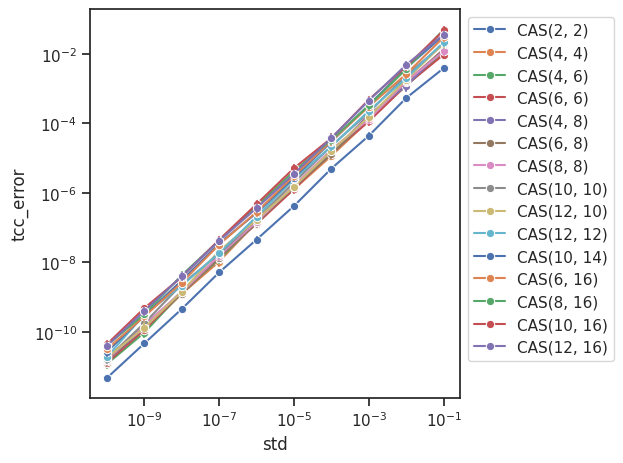

In [3]:
def analyze_noise_data(row):
    df = row.df
    nalpha, nbeta, ncas = row.nalpha, row.nbeta, row.nact
    cas = f"CAS({nalpha+nbeta}, {ncas})"
    sns.set_theme(style="ticks")
    ax = sns.lineplot(data=df, x="std", y="tcc_error", markers=True, err_style="bars", marker="o", label=cas)
    ax.set_yscale("log")
    ax.set_xscale("log")
    stds = np.unique(df['std'])
    # # TODO: fit using mean over realizations
    errors_mean = df.groupby("std").mean().tcc_error.values
    a, b, fun = power_law_fit(stds, errors_mean)
    print(a, b)


    # xx = np.logspace(-10, -1, num=1000, endpoint=True)
    # sns.lineplot(x=xx, y=fun(xx), label="power law fit", ax=ax)
    # sns.lineplot(x=stds, y=errors_mean, label="mean", ax=ax, marker="x", markers=True)
    # plt.title(cas)
    # plt.savefig(f"error_noise_{cas}.png")
    return a, b


# data = pd.read_hdf("noise_data_formaldehyde.h5", key="df")
data = pd.read_hdf("noise_data_n2_real.h5", key="df")

# data = pd.read_hdf("noise_data_acetaldehyde.h5", key="df")

# data = pd.read_hdf("noise_data_n2_stretched.h5", key="df")
print("Before NaN filter:", len(data.index))
data = data[data['df'].notna()]
print("After NaN filter:", len(data.index))
# print(data)

data['ncas'] = data.nact
data['nocc'] = data.nalpha + data.nbeta
data['nvirt'] = 2 * data.ncas - data.nocc
data['nvirta'] = data.nact - data.nalpha
data['nvirtb'] = data.nact - data.nbeta

# singles = compute_nonredundant(data.nact, data.nalpha, 1) + compute_nonredundant(data.nact, data.nbeta, 1)
# doubles = compute_nonredundant(data.nact, data.nalpha, 2) + compute_nonredundant(data.nact, data.nbeta, 2)
# data['noverlaps'] = 1 + singles + doubles + (data.nalpha * data.nbeta * data.nvirta * data.nvirtb)

from tailoredcc.amplitudes import number_overlaps_tccsd, number_overlaps_eccc
data['noverlaps'] = number_overlaps_tccsd(data.nact, data.nalpha, data.nbeta)
data['noverlaps_ec'] = number_overlaps_eccc(data.nact, data.nalpha, data.nbeta)


data['cas'] = data.apply(lambda row: f"({row.nalpha + row.nbeta}, {row.nact})", axis=1)
data[['a', 'b']] = data.apply(analyze_noise_data, axis=1, result_type='expand')

plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.tight_layout()

In [4]:
data[['cas', 'noverlaps', 'noverlaps_ec']].to_latex("cas_info_sigma.tex", index=False)

In [5]:
# data = pd.read_hdf("noise_data_n2_real.h5", key="df")
# data['molname'] = "n2_real"

# data2 = pd.read_hdf("noise_data_formaldehyde.h5", key="df")
# data2['molname'] = "formaldehyde"

# data3 = pd.read_hdf("noise_data_acetaldehyde.h5", key="df")
# data3['molname'] = "acetaldehyde"

# data4 = pd.read_hdf("noise_data_n2_stretched.h5", key="df")
# data4["molname"] = "n2_stretched"

# data = pd.concat([data, data2, data3, data4])

merged_df = pd.DataFrame()
for _, row in data.iterrows():
    # Access the inner dataframe from the current row
    inner_df = row['df']
    # Add the 'noverlap' column to the inner dataframe
    inner_df['noverlaps'] = row['noverlaps']
    # Concatenate the inner dataframe with the merged dataframe
    merged_df = pd.concat([merged_df, inner_df])
# Reset the index of the merged dataframe
merged_df.reset_index(drop=True, inplace=True)

power_law_fit(merged_df['std'], merged_df.tcc_error)


sigma [0.00985649 0.00158852]


(0.18313292343032353,
 0.9997609191497842,
 functools.partial(<function power_law at 0x7f0885131a60>, a=0.18313292343032353, b=0.9997609191497842))

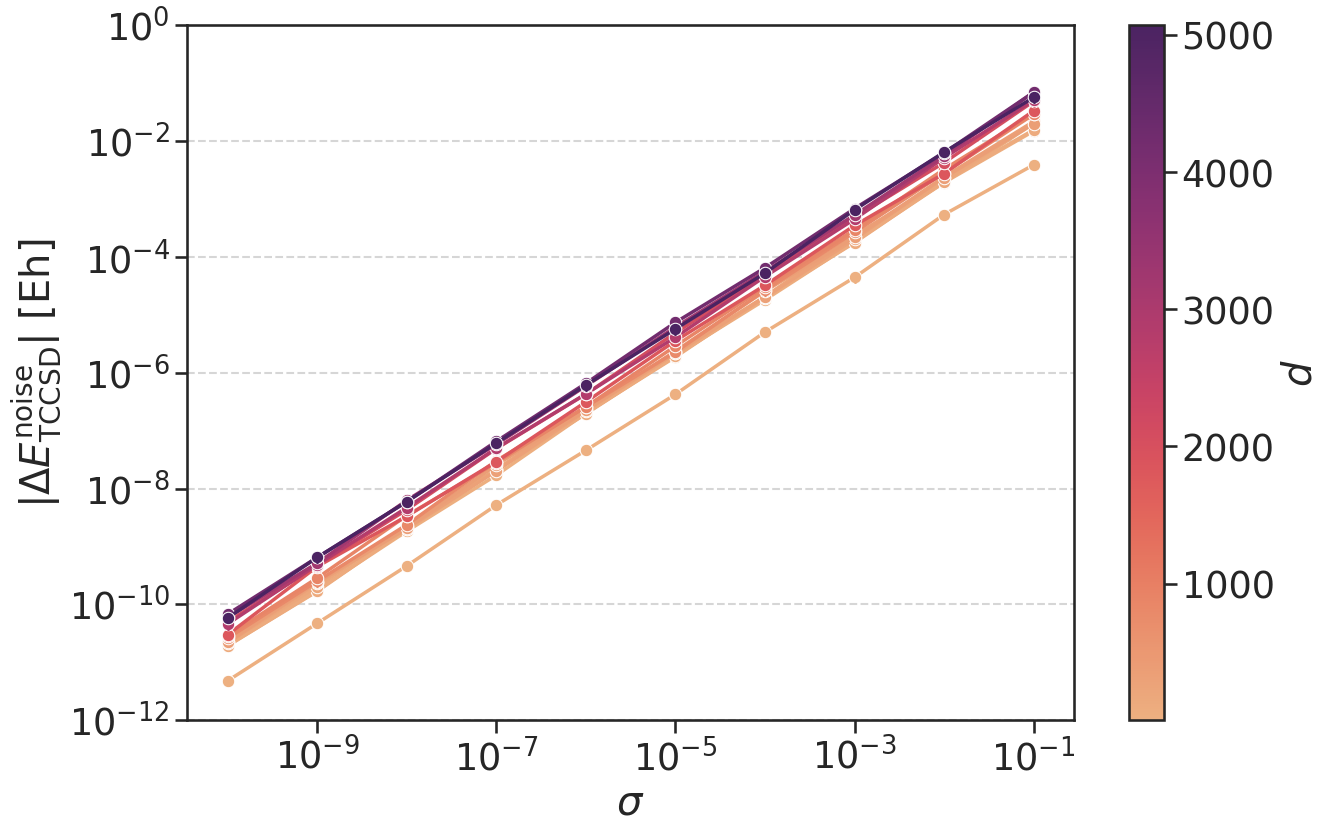

In [6]:
import matplotlib as mpl
import matplotlib.colors as colors
sns.set_theme(context="talk", font_scale=1.6, style="ticks")
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(14, 9)
sns.lineplot(
    ax=ax, data=merged_df, x="std", y="tcc_error", hue="noverlaps",
    markers=True, err_style="bars", marker="o", linewidth=2.5,
    palette="flare",
    # legend="full",
    # legend="brief",
    # hue_norm=mpl.colors.LogNorm()
)
ax.set_yscale("log")
ax.set_xscale("log")
# ax.set_xlabel(r"$\sigma_\mathrm{noise}$")
ax.set_xlabel(r"$\sigma$")
ax.set_ylabel(r"$|\Delta E^\mathrm{noise}_\mathrm{TCCSD}|$ [Eh]")

ax.get_legend().remove()

sm = plt.cm.ScalarMappable(
    cmap="flare",
    # norm=colors.LogNorm(vmin=merged_df['noverlaps'].min(), vmax=merged_df['noverlaps'].max()),
    norm=colors.Normalize(vmin=merged_df['noverlaps'].min(), vmax=merged_df['noverlaps'].max()),
)
# sm.set_array([])
ax.figure.colorbar(
    sm, ax=ax,
    # extend="max",
    label=r"$d$"
)
ax.set_ylim(1e-12, 1e-0)
ax.yaxis.grid(True, linestyle="--", alpha=0.8)

# import matplotlib.ticker as ticker
# handles, labels = ax.get_legend_handles_labels()
# formatter = ticker.ScalarFormatter(useMathText=True)
# formatter.set_powerlimits((1, 5))
# labels = [f"${formatter.format_data(int(label))}$" for label in labels]

# linewidth = 4.0
# for handle in handles:
#     handle.set_linewidth(linewidth)

# Create a new legend with the updated labels
# ax.legend(handles, labels, title=r"$n_\mathrm{overlap}$")
plt.tight_layout()
plt.savefig("noise_tcc_colorbar.png", dpi=300)
plt.savefig("noise_tcc_colorbar.pdf", dpi=300)

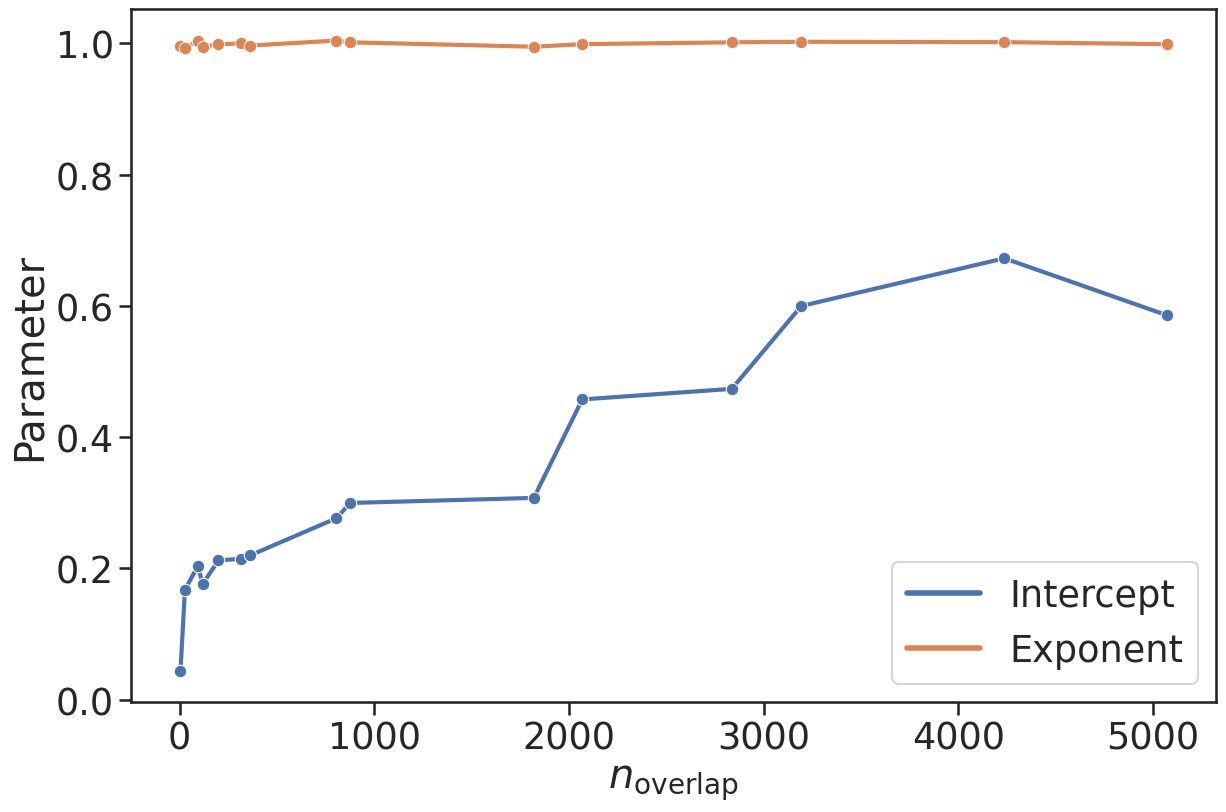

In [7]:
# ax = sns.lineplot(data=data, x="noverlaps", y="a", marker="o")
# ax.set_xscale('log')
# ax.set_yscale('log')
dfm = pd.melt(data, id_vars="noverlaps", value_vars=["a", "b"], value_name="parameter", var_name="fit")

sns.set_theme(context="talk", font_scale=1.6, style="ticks")
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(14, 9)
sns.lineplot(
    ax=ax,
    data=dfm, x="noverlaps", y="parameter", hue="fit",
    markers=True,
    marker="o",
    linewidth=3,
    # palette="flare",
    # legend="full",
    # hue_norm=mpl.colors.LogNorm()
)
# ax.set_yscale("log")
# ax.set_xscale("log")
ax.set_xlabel(r"$n_\mathrm{overlap}$")
ax.set_ylabel("Parameter")

handles, labels = ax.get_legend_handles_labels()
linewidth = 4.0
for handle in handles:
    handle.set_linewidth(linewidth)

labels = ["Intercept", "Exponent"]
# Create a new legend with the updated labels
ax.legend(handles, labels, title="")

/fs/home/cvsik/miniforge3/envs/tcc/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                                 OLS Regression Results                                
Dep. Variable:                      a   R-squared (uncentered):                   0.858
Model:                            OLS   Adj. R-squared (uncentered):              0.848
Method:                 Least Squares   F-statistic:                              84.51
Date:                Wed, 13 Dec 2023   Prob (F-statistic):                    2.62e-07
Time:                        11:13:56   Log-Likelihood:                          8.1276
No. Observations:                  15   AIC:                                     -14.26
Df Residuals:                      14   BIC:                                     -13.55
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

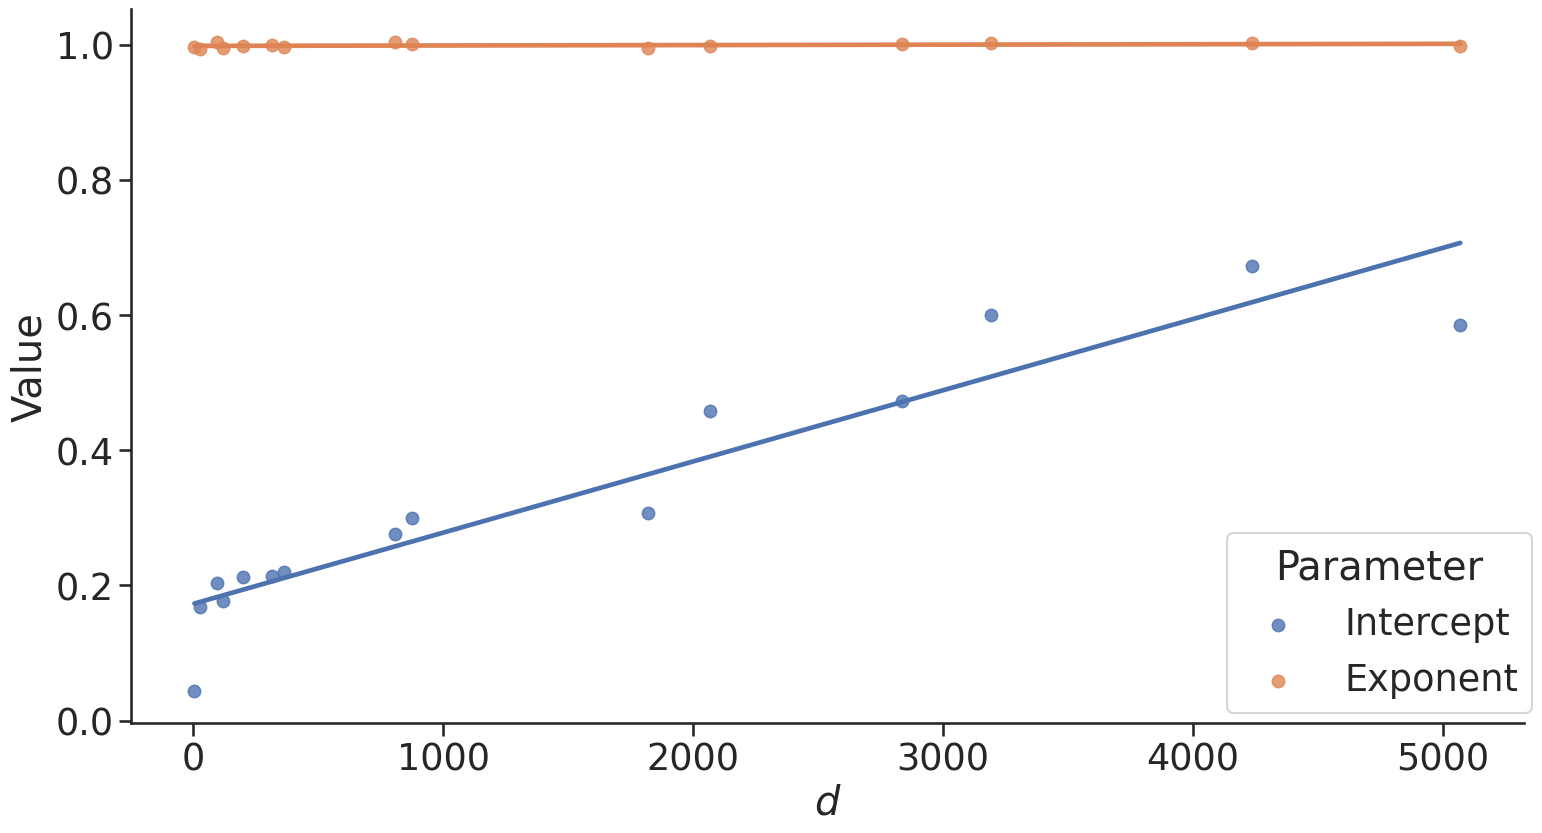

In [8]:
g = sns.lmplot(
    data=dfm,
    x="noverlaps", y="parameter", hue="fit",
    height=9,
    # robust=True,
    ci=None,
)

import statsmodels.api as sm

X = data.noverlaps
# X = sm.add_constant(X)
model = sm.OLS(data.a, X)
results = model.fit()
print(results.summary())

# Use more informative axis labels than are provided by default
g.set_axis_labels(r"$d$", "Value")
g.legend.texts[0].set_text("Intercept")
g.legend.texts[1].set_text("Exponent")
g.fig.set_size_inches(16, 9)
sns.move_legend(g, "lower right", bbox_to_anchor=(0.99, 0.15), title="Parameter", frameon=True, ncol=1)
plt.tight_layout()
# plt.savefig("powerlaw_fit_trend.png", dpi=300)